In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Database connection parameters
db_params = {
    'dbname': 'week1',
    'user': 'postgres',
    'password': 'habte',
    'host': 'localhost',
    'port': '5432'
}

# Create a SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')

# SQL query to retrieve data
sql_query = "SELECT * FROM xdr_data;"

# Read data from PostgreSQL into a DataFrame
mydata = pd.read_sql_query(sql_query, engine)

In [4]:
# Display basic information about the DataFrame
print(mydata.info())

# Display summary statistics of numerical columns
print(mydata.describe())

# Display the first few rows of the DataFrame
print(mydata.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [5]:
# Explore unique values in user-related columns (IMSI, MSISDN/Number, IMEI)
print(mydata['IMSI'].nunique())
print(mydata['MSISDN/Number'].nunique())
print(mydata['IMEI'].nunique())


107265
106856
107270


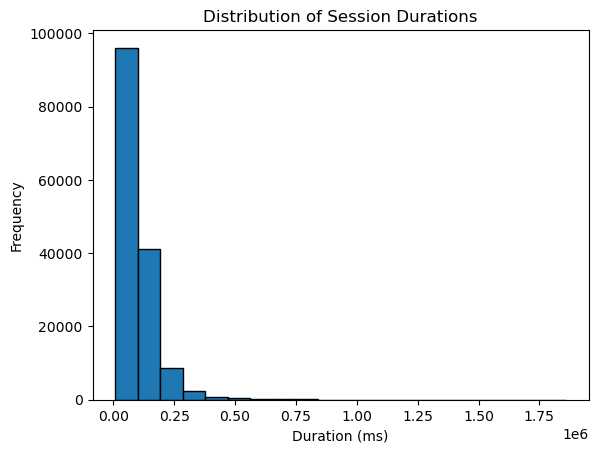

In [6]:
# Visualize the distribution of session durations
import matplotlib.pyplot as plt

plt.hist(mydata['Dur. (ms)'], bins=20, edgecolor='black')
plt.title('Distribution of Session Durations')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.show()

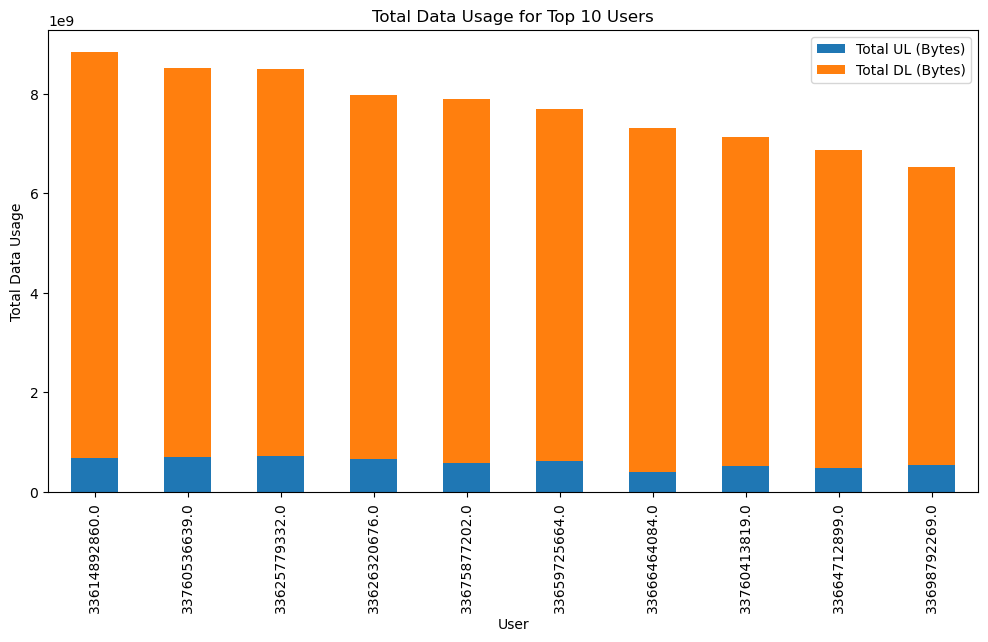

In [7]:
# Calculate total data usage for each user
user_total_data = mydata.groupby('MSISDN/Number')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum()

# Select the top 10 users based on total data usage
top_10_users = user_total_data.sum(axis=1).nlargest(10).index
top_10_data = user_total_data.loc[top_10_users]

# Visualize total data usage for the top 10 users
top_10_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Data Usage for Top 10 Users')
plt.xlabel('User')
plt.ylabel('Total Data Usage')
plt.show()


In [8]:
# Convert 'Start' column to datetime for temporal analysis
mydata['Start'] = pd.to_datetime(mydata['Start'])



In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming 'Start' is the column indicating the start date of user activity
mydata['Start'] = pd.to_datetime(mydata['Start'])

# Define churn based on users who haven't used the service in the last 30 days
churn_threshold = pd.to_datetime('today') - pd.DateOffset(days=30)
mydata['Churn'] = (mydata['Start'] < churn_threshold).astype(int)

# Features and target variable
features = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
            'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
            'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
            'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
            '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
            'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Nb of sec with 125000B < Vol DL',
            'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B',
            'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B',
            'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B',
            'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
            'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)',
            'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
            'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
            'Total UL (Bytes)', 'Total DL (Bytes)']

target = 'Churn'

# Drop rows with missing values for simplicity (you may need to handle missing values more robustly)
model_data = mydata.dropna(subset=[target] + features)

# Split data into training and testing sets
X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      3544

    accuracy                           1.00      3544
   macro avg       1.00      1.00      1.00      3544
weighted avg       1.00      1.00      1.00      3544



In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming 'Start' is the column indicating the start date of user activity
mydata['Start'] = pd.to_datetime(mydata['Start'])

# Define churn based on users who haven't used the service in the last 30 days
churn_threshold = pd.to_datetime('today') - pd.DateOffset(days=30)
mydata['Churn'] = (mydata['Start'] < churn_threshold).astype(int)

# Features and target variable
features = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
            'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
            'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
            'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
            '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
            'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Nb of sec with 125000B < Vol DL',
            'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B',
            'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B',
            'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B',
            'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
            'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)',
            'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
            'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
            'Total UL (Bytes)', 'Total DL (Bytes)']

target = 'Churn'

# Drop rows with missing values for simplicity (you may need to handle missing values more robustly)
model_data = mydata.dropna(subset=[target] + features)

# Split data into training and testing sets
X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Perform cross-validation
cv_scores = cross_val_score(clf, scaler.transform(X), y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Print feature importances
feature_importances = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances)

# Make predictions and evaluate the model on the test set
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print("Classification Report:\n", classification_rep)


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0
Feature Importances:
                                      Feature  Importance
0                            Avg RTT DL (ms)         0.0
31                          Email UL (Bytes)         0.0
23    Nb of sec with 6250B < Vol UL < 37500B         0.0
24             Nb of sec with Vol DL < 6250B         0.0
25             Nb of sec with Vol UL < 1250B         0.0
26                   Social Media DL (Bytes)         0.0
27                   Social Media UL (Bytes)         0.0
28                         Google DL (Bytes)         0.0
29                         Google UL (Bytes)         0.0
30                          Email DL (Bytes)         0.0
32                        Youtube DL (Bytes)         0.0
1                            Avg RTT UL (ms)         0.0
33                        Youtube UL (Bytes)         0.0
34                        Netflix DL (Bytes)         0.0
35                        Netflix UL (Bytes)         0.0
36

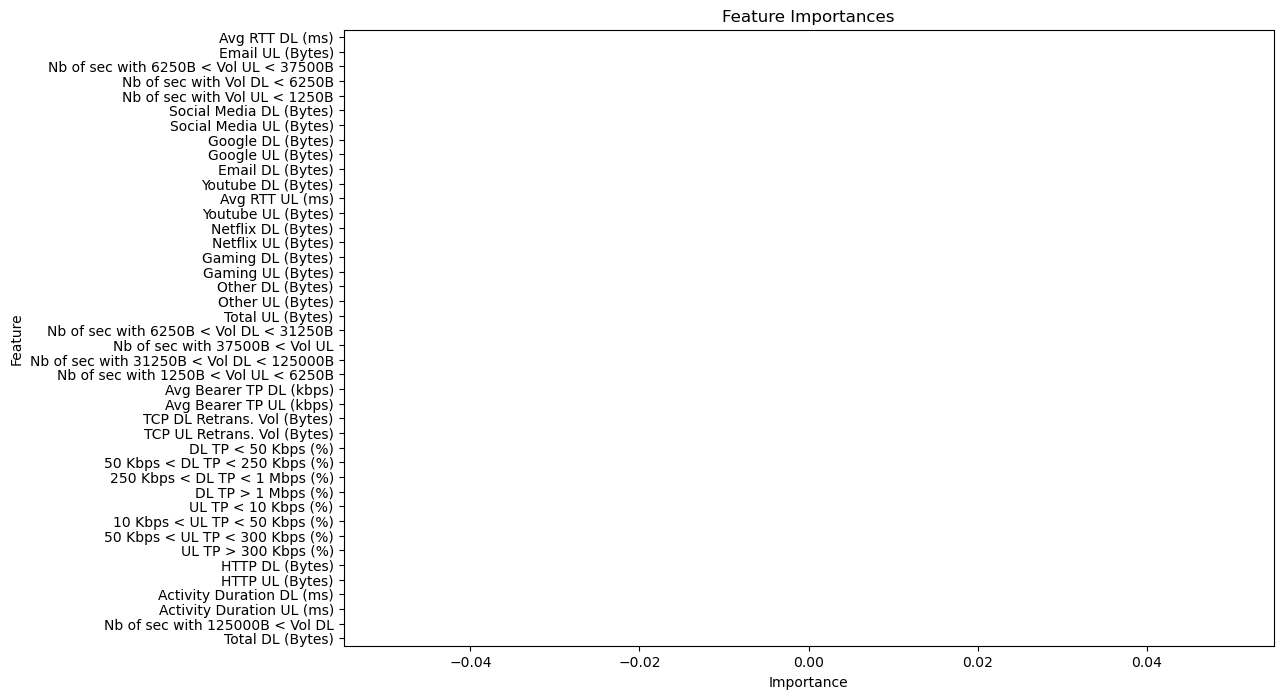

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'feature_importances' is a DataFrame containing Feature and Importance columns
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': [0.0] * len(features)  # Initialize with zeros or replace with actual importances
})

# Sort the features based on importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


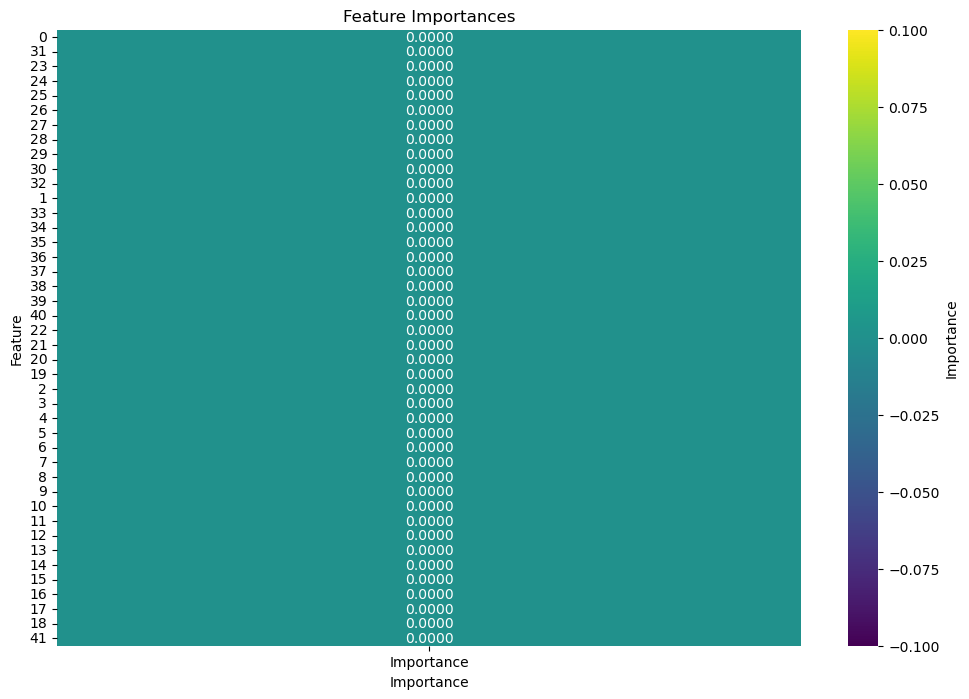

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'feature_importances' is a DataFrame containing Feature and Importance columns
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': [0.0] * len(features)  # Initialize with zeros or replace with actual importances
})

# Sort the features based on importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_importances[['Importance']], annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Importance'})
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [13]:
# Check unique values in each column
for column in mydata.columns:
    unique_values = mydata[column].unique()
    print(f'{column}: {unique_values}')

Bearer Id: [1.31144835e+19 1.31144835e+19 1.31144835e+19 ... 7.27782567e+18
 7.34988326e+18 1.31144836e+19]
Start: <DatetimeArray>
['2019-04-04 12:01:00', '2019-04-09 13:04:00', '2019-04-09 17:42:00',
 '2019-04-10 00:31:00', '2019-04-12 20:10:00', '2019-04-12 21:37:00',
 '2019-04-13 08:41:00', '2019-04-14 02:11:00', '2019-04-14 12:48:00',
 '2019-04-15 00:32:00',
 ...
 '2019-04-29 07:20:00', '2019-04-29 07:21:00', '2019-04-29 07:25:00',
 '2019-04-29 07:22:00', '2019-04-29 07:23:00', '2019-04-29 07:24:00',
 '2019-04-29 07:26:00', '2019-04-29 07:27:00', '2019-04-29 07:28:00',
                 'NaT']
Length: 9998, dtype: datetime64[ns]
Start ms: [770. 235.   1. ... 431.  95.  nan]
End: ['4/25/2019 14:35' '4/25/2019 8:15' '4/25/2019 11:58' ...
 '4/30/2019 23:18' '4/30/2019 22:32' None]
End ms: [662. 606. 652. ...  91. 499.  nan]
Dur. (ms): [1823652. 1365104. 1361762. ...   81230.   98249.      nan]
IMSI: [2.08201448e+14 2.08201909e+14 2.08200314e+14 ... 2.08202201e+14
 2.08201711e+14 2.0820

Avg Bearer TP DL (kbps): [2.3000e+01 1.6000e+01 6.0000e+00 ... 3.0741e+04 6.3420e+04        nan]
Avg Bearer TP UL (kbps): [4.4000e+01 2.6000e+01 9.0000e+00 ... 1.4822e+04 3.6754e+04        nan]
TCP DL Retrans. Vol (Bytes): [          nan 1.9520000e+04 3.2313970e+06 ... 8.3246000e+04 2.2880000e+03
 1.6552848e+07]
TCP UL Retrans. Vol (Bytes): [    nan   7230. 312007. ...   9136.   2770. 162614.]
DL TP < 50 Kbps (%): [100.  99.  70.  68.  nan  73.  91.  79.  89.  94.  90.  88.  66.  84.
  74.  93.  58.  76.  60.  98.  87.  25.  97.  86.  72.  61.  96.  67.
  56.  92.  71.  47.  81.  95.  48.  82.  54.  80.  77.  83.  85.  31.
  42.  37.  50.  44.  75.  64.  57.  78.  55.  49.  38.  30.  65.  51.
  23.  63.  53.  69.  29.  62.  35.   8.  59.  52.  34.  27.  41.  46.
  14.  43.  33.  45.  18.  36.  40.  11.  28.   0.  21.  32.  16.  17.
  39.  19.  13.  12.  26.  15.  24.  22.   2.  10.   9.   6.   4.  20.
   7.   3.   5.]
50 Kbps < DL TP < 250 Kbps (%): [ 0. 26. 17. nan 20.  4. 16.  5. 14.

Nb of sec with Vol UL < 1250B: [  214.  1022.   695. ... 23973. 12000. 43438.]
Social Media DL (Bytes): [1545765.         1926113.         1684053.         ... 1245845.
  801547.         1795321.77364667]
Social Media UL (Bytes): [24420.       7165.      42224.      ... 21860.      21562.
 32928.43438]
Google DL (Bytes): [1634479.         3493924.         8535055.         ... 3850890.
 4189773.         5750752.61928667]
Google UL (Bytes): [1271433.          920172.         1694064.         ... 2734579.
 3567494.         2056541.92628667]
Email DL (Bytes): [3563542.       629046.      2690151.      ... 1525734.      2228270.
 1791728.86802]
Email UL (Bytes): [137762.      308339.      672973.      ... 532543.      622644.
 467373.44194]
Youtube DL (Bytes): [15854611.     20247395.     19725661.     ... 22660510.      8817106.
 11634072.5039]
Youtube UL (Bytes): [ 2501332.     19111729.     14699576.     ...  1855903.      8305402.
 11009410.1347]
Netflix DL (Bytes): [ 8198936.      1833

In [15]:
import pandas as pd
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go

# Convert 'Start' column to datetime for temporal analysis
mydata['Start'] = pd.to_datetime(mydata['Start'])

# Explore time-of-day and day-of-week patterns
mydata['Hour'] = mydata['Start'].dt.hour
mydata['DayOfWeek'] = mydata['Start'].dt.day_name()

# Get unique values in the 'Churn' column
churn_values = mydata['Churn'].unique()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("User Overview Analysis"),
    
    # Dropdown for selecting churn status
    dcc.Dropdown(
        id='churn-dropdown',
        options=[{'label': churn, 'value': churn} for churn in churn_values],
        value=churn_values[0],  # Default value
        multi=False,
        style={'width': '50%'}
    ),
    
    # Bar chart for total data usage
    dcc.Graph(id='total-data-usage-bar-chart'),
    
    # Histogram for session duration distribution
    dcc.Graph(id='session-duration-histogram'),
    
    # Line chart for average data usage by hour
    dcc.Graph(id='average-data-usage-by-hour-line-chart'),
    
    # Bar chart for average data usage by day of the week
    dcc.Graph(id='average-data-usage-by-day-of-week-bar-chart'),

])

# Define callback to update charts based on selected churn status
@app.callback(
    [
        dash.dependencies.Output('total-data-usage-bar-chart', 'figure'),
        dash.dependencies.Output('session-duration-histogram', 'figure'),
        dash.dependencies.Output('average-data-usage-by-hour-line-chart', 'figure'),
        dash.dependencies.Output('average-data-usage-by-day-of-week-bar-chart', 'figure')
    ],
    [dash.dependencies.Input('churn-dropdown', 'value')]
)
def update_charts(selected_churn_status):
    # Filter data based on selected churn status
    filtered_data = mydata[mydata['Churn'] == selected_churn_status]
    
    # Calculate total data usage for each user in the filtered data
    filtered_user_total_data = filtered_data.groupby('MSISDN/Number')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum()
    
    # Bar chart for total data usage
    total_data_fig = px.bar(filtered_user_total_data, x=filtered_user_total_data.index,
                            y=['Total UL (Bytes)', 'Total DL (Bytes)'],
                            labels={'value': 'Total Data Usage', 'variable': 'Data Type'},
                            title=f'Total Data Usage for {selected_churn_status} Users',
                            barmode='stack')
    
    # Histogram for session duration distribution
    session_duration_fig = go.Figure()
    session_duration_fig.add_trace(go.Histogram(x=filtered_data['Dur. (ms)'], nbinsx=20,
                                                marker_color='skyblue', opacity=0.7))
    session_duration_fig.update_layout(title_text='Distribution of Session Durations',
                                       xaxis_title='Duration (ms)',
                                       yaxis_title='Frequency')
    
    # Line chart for average data usage by hour
    average_data_by_hour_fig = px.bar(filtered_data.groupby('Hour')['Total DL (Bytes)'].mean().reset_index(),
                                      x='Hour', y='Total DL (Bytes)', labels={'Total DL (Bytes)': 'Average Data Usage'},
                                      title='Average Data Usage by Hour')
    
    # Bar chart for average data usage by day of the week
    average_data_by_day_of_week_fig = px.bar(
        filtered_data.groupby('DayOfWeek')['Total DL (Bytes)'].mean().reindex(
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        ).reset_index(),
        x='DayOfWeek', y='Total DL (Bytes)', labels={'Total DL (Bytes)': 'Average Data Usage'},
        title='Average Data Usage by Day of Week'
    )
    
    return total_data_fig, session_duration_fig, average_data_by_hour_fig, average_data_by_day_of_week_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
